In [16]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import random
from scipy.stats.distributions import t
import pandas as pd
import datetime
# np.set_printoptions(precision=2)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
random_seed = 39
random.seed(random_seed)
np.random.seed(random_seed)

In [17]:
data = pd.read_csv("/content/axNSsVJtVBJbNUgD.gzip", compression='gzip')
data['date'] = pd.to_datetime(data['date'])

In [23]:
def get_x(data):
    res = []
    for i in pd.unique(data['id_user']):
        x = data[data['id_user'] == i].sort_values(by=['date'])
        s = x.iloc[0]['date'] + datetime.timedelta(days=7)
        p = x[x['date'] < s]['sum_payment'].sum()
        res.append(p)
    return np.array(res)

In [24]:
pred_data = data[data['group'].isnull()]
pred_g = get_x(pred_data)

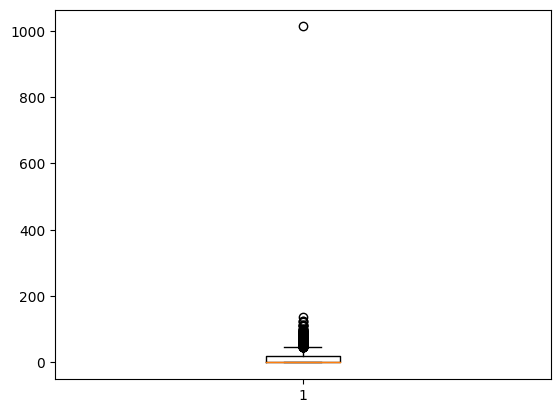

In [25]:
_ = plt.boxplot(pred_g)

Наблюдается очень много выбросов, выбросом будем считать значения, превосходящие 75% перцентиль плюс 1.5 * МКР

In [26]:
def normilize(x):
    p_ma = np.quantile(x, 0.75)
    p_mi = np.quantile(x, 0.25)
    ma = p_ma + 1.5 * (p_ma - p_mi)
    return np.array([i for i in x if i < ma])
pred_g = normilize(pred_g)

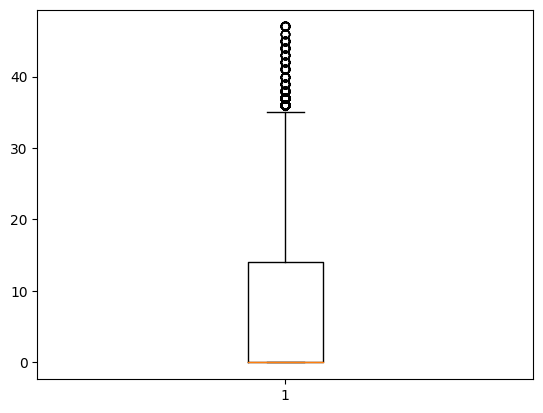

In [27]:
_ = plt.boxplot(pred_g)

In [28]:
def get_dur(k, d_eff, sigma_1, sigma_2, alpha=0.05, beta=0.2):
    stat = sps.norm.ppf(1 - alpha/2) + sps.norm.ppf(1-beta)
    n = (k+1) * stat ** 2 * (sigma_1 ** 2 + sigma_2 **2 / k) / (d_eff ** 2)
    n = int(np.ceil(n))
    return n

n = get_dur(1, pred_g.mean() * 0.1, pred_g.std(), pred_g.std())
print(f"Длительность: {n}")

Длительность: 6676


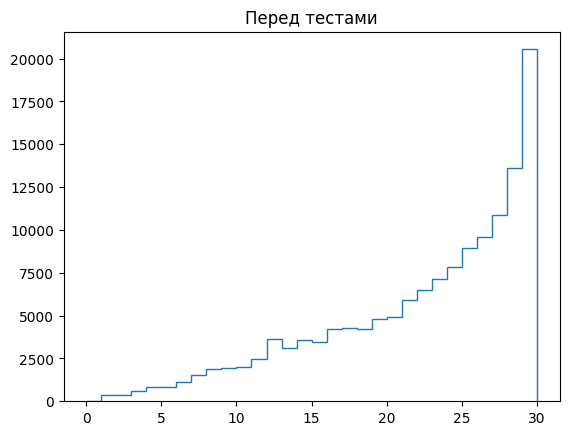

In [29]:
def make_plot(pred_data, s):
    l = []
    for i in pd.unique(pred_data['date']):
        x = pred_data[pred_data['date'] == i]['sum_payment']
        l.append([i, x.sum()])
    l.sort(key = lambda x: x[0])
    plt.stairs([i[1] for i in l], range(len(l) + 1))
    plt.title(s)
make_plot(pred_data, "Перед тестами")

In [30]:
data_a = data[data['group'] == "A"]
data_b = data[data['group'] == "B"]

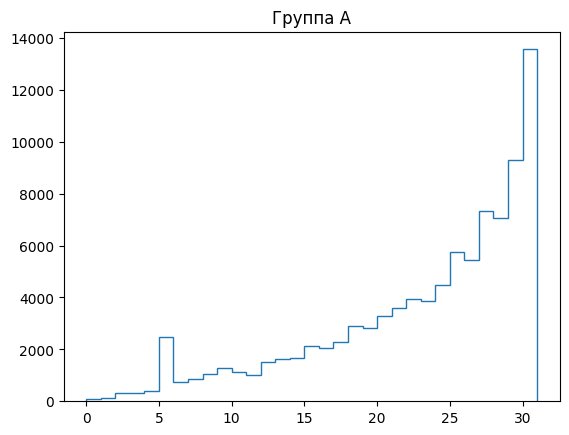

In [31]:
make_plot(data_a, "Группа A")

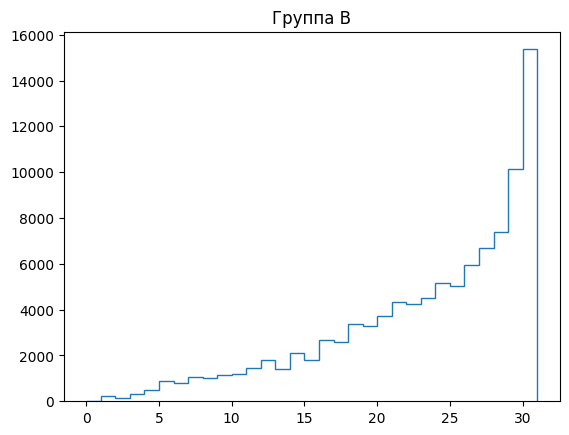

In [33]:
make_plot(data_b, "Группа B")

В данных замечено существенное изменение суммы покупок к концу месяца. Поэтому было принятно решение посчитать p_value для всех возможных дней, пока выборка позволяет, и уже из полученных значений делать выводы.

In [44]:
for i in range(7, 32):
    s = pd.Timestamp(2023, 5, 1) + datetime.timedelta(days=i)
    u = s - datetime.timedelta(days=7)
    a_g = get_x(data_a[data_a['date'] < s])
    b_g = get_x(data_b[data_b['date'] < s])
    a_g = normilize(a_g)
    b_g = normilize(b_g)
    if len(a_g) < n / 2 or len(b_g) < n / 2:
        continue
    print(f"date = {s}, size A = {len(a_g)}, size B = {len(b_g)}, pvalue = {np.round(sps.ttest_ind(a_g, b_g, alternative = 'less').pvalue, 5)}")

date = 2023-05-26 00:00:00, size A = 3380, size B = 3576, pvalue = 0.0
date = 2023-05-27 00:00:00, size A = 3689, size B = 3864, pvalue = 0.0
date = 2023-05-28 00:00:00, size A = 3955, size B = 4139, pvalue = 0.0
date = 2023-05-29 00:00:00, size A = 4212, size B = 4454, pvalue = 0.0
date = 2023-05-30 00:00:00, size A = 4542, size B = 4792, pvalue = 0.0
date = 2023-05-31 00:00:00, size A = 5248, size B = 5198, pvalue = 0.00058
date = 2023-06-01 00:00:00, size A = 5725, size B = 5785, pvalue = 0.0


Теперь без удаления выбросов:

In [43]:
for i in range(7, 32):
    s = pd.Timestamp(2023, 5, 1) + datetime.timedelta(days=i)
    u = s - datetime.timedelta(days=7)
    a_g = get_x(data_a[data_a['date'] < s])
    b_g = get_x(data_b[data_b['date'] < s])
    if len(a_g) < n / 2 or len(b_g) < n / 2:
        continue
    print(f"date = {s}, size A = {len(a_g)}, size B = {len(b_g)}, pvalue = {np.round(sps.ttest_ind(a_g, b_g, alternative = 'less').pvalue, 5)}")

date = 2023-05-25 00:00:00, size A = 3449, size B = 3434, pvalue = 0.11459
date = 2023-05-26 00:00:00, size A = 3734, size B = 3719, pvalue = 0.08468
date = 2023-05-27 00:00:00, size A = 4084, size B = 4025, pvalue = 0.066
date = 2023-05-28 00:00:00, size A = 4387, size B = 4301, pvalue = 0.03803
date = 2023-05-29 00:00:00, size A = 4696, size B = 4642, pvalue = 0.07421
date = 2023-05-30 00:00:00, size A = 5074, size B = 5004, pvalue = 0.04589
date = 2023-05-31 00:00:00, size A = 5482, size B = 5450, pvalue = 0.0684
date = 2023-06-01 00:00:00, size A = 6000, size B = 6000, pvalue = 0.03483


Удаление выбросов существенно влияет на результат

По полученным результатам делается вывод об отвержении нулевой гипотезы: средний доход от пользователя за неделю возрастет